## Milestone 3 (Additional Plots)

<b>Zach Simms<b>

This notebook presents additional analyses for Milestone 3, focusing on advanced visualization of weather forecast data using the GEFS and GFS models. The primary objectives are:

- To explore ensemble spread and relationships in GEFS forecast variables using scatterplots,
- To visualize GFS model rainfall forecasts spatially,
- To map 10-meter wind speed and direction from the GFS model.

Imported GEFS and GFS data using Herbie.

## Step 1

Import all necessary modules.

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from herbie import Herbie
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib

## Step 2

This step plots and visualizes scatterplots derived from the GEFS ensemble forecast data. Scatterplots are useful for examining the relationships and spread among ensemble members for selected variables.

- The data is extracted from GEFS forecast files via Herbie for a specific model run and forecast hour.
- Scatterplots help assess ensemble variability and forecast uncertainty.
- This visualization provides insight into the distribution and correlation of forecast variables across ensemble members.

We can see from the plot that only a few of the ensemble members were close to the observed track of Hurricane Ian. Many of the tracks actually had Ian making landfall further up the west coast of Florida, or at least trended to track that way.

✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F114 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F120 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F126 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F132 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F138 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F144 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F150 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F114 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F120 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊ 2022-Sep-23 00:00 UTC F126 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gefs ┊ product=atmos.5 ┊

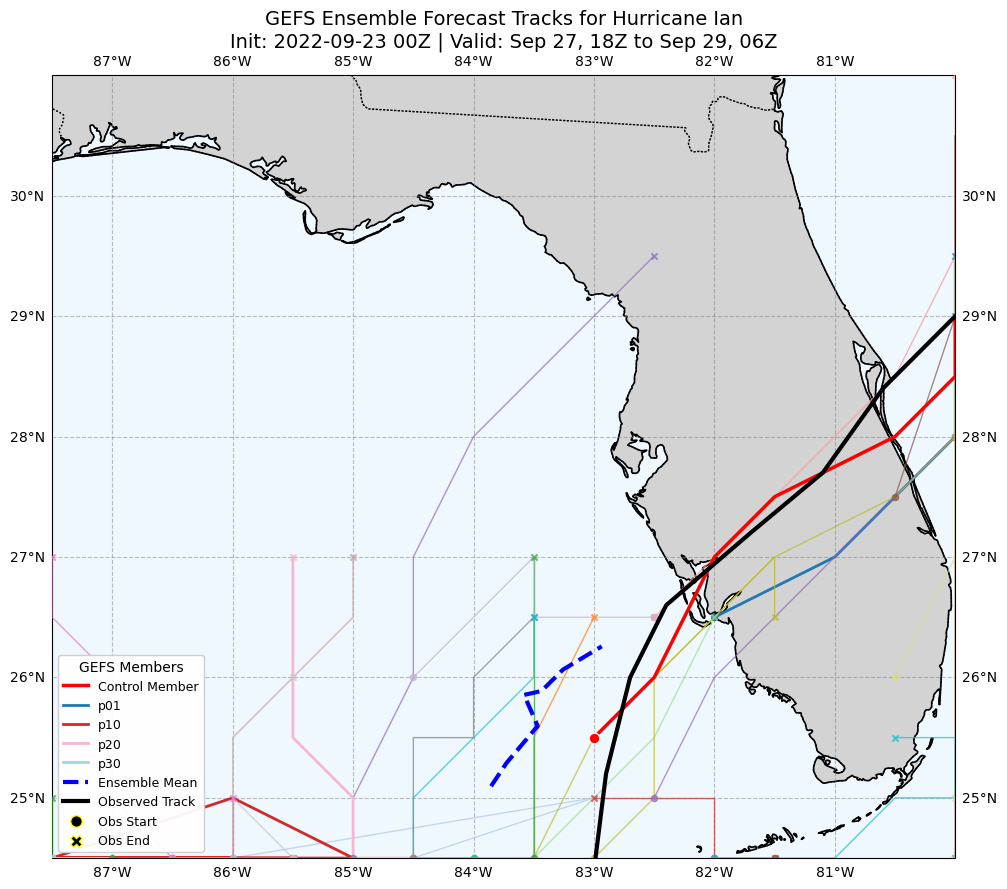

In [58]:
# Set bounds for Florida
florida_bounds = {
    'lat_min': 24.5,
    'lat_max': 31.0,
    'lon_min': -87.5,
    'lon_max': -80.0
}

# Read in observed track and sort latitudes and longitudes
observed_track = pd.read_csv("/home/zas5258/meteo473/ianpreliminarytrack.csv")
obs_lats = observed_track['LAT']
obs_lons = observed_track['LON']

# Forecast initialization time
forecast_run_date = dt.datetime(2022, 9, 23, 0)

# Ensemble members: control + perturbations
members = ["c00"] + [f"p{str(i).zfill(2)}" for i in range(1, 31)]
forecast_hours = range(114, 156, 6)

# Dictionary to store tracks
ensemble_tracks = {member: [] for member in members}

# Loop over members and forecast hours
for member in members:
    for fxx in forecast_hours:
        try:
            H = Herbie(forecast_run_date, model="gefs", product="atmos.5", member=member, fxx=fxx)
            H.download()
            ds = H.xarray("PRMSL:mean sea level")
            ds = ds[0] if isinstance(ds, list) else ds
            ds = ds.assign_coords(longitude=(((ds.longitude + 180) % 360) - 180)).sortby("longitude")

            ds_fl = ds.sel(
                latitude=slice(florida_bounds["lat_max"], florida_bounds["lat_min"]),
                longitude=slice(florida_bounds["lon_min"], florida_bounds["lon_max"])
            )

            min_idx = np.unravel_index(np.argmin(ds_fl["prmsl"].values), ds_fl["prmsl"].shape)
            storm_lat = ds_fl.latitude.values[min_idx[0]]
            storm_lon = ds_fl.longitude.values[min_idx[1]]

            ensemble_tracks[member].append((storm_lon, storm_lat))

        except Exception as e:
            print(f"{member} failed at fxx={fxx}: {e}")

# Calculate ensemble mean track
ensemble_mean = []
for i in range(len(forecast_hours)):
    lons = []
    lats = []
    for member in members:
        if len(ensemble_tracks[member]) == len(forecast_hours):
            lon, lat = ensemble_tracks[member][i]
            lons.append(lon)
            lats.append(lat)
    if lons and lats:
        ensemble_mean.append((np.mean(lons), np.mean(lats)))
mean_lons, mean_lats = zip(*ensemble_mean)

# Plotting
fig, ax = plt.subplots(figsize=(11, 9), subplot_kw={"projection": ccrs.PlateCarree()})
ax.set_extent([florida_bounds["lon_min"], florida_bounds["lon_max"], florida_bounds["lat_min"], florida_bounds["lat_max"]])
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgray')
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='aliceblue')
ax.add_feature(cfeature.COASTLINE, linewidth=1.2)
ax.add_feature(cfeature.STATES, linestyle=":", linewidth=1)
ax.gridlines(draw_labels=True, linestyle="--", color="gray", alpha=0.5)

# Color map for ensemble members
cmap = matplotlib.colormaps['tab20'].resampled(len(members))

# Plot each ensemble track
for idx, (member, track) in enumerate(ensemble_tracks.items()):
    if track:
        lons, lats = zip(*track)
        if member == "c00":
            ax.plot(lons, lats, color='red', linewidth=2.5, label='Control Member', zorder=6)
            ax.scatter(lons[0], lats[0], color='red', edgecolor='white', s=60, zorder=7)
        else:
            ax.plot(lons, lats, color=cmap(idx), linewidth=1, alpha=0.7, zorder=5)
            # Optionally highlight a few members in legend
            if member in ["p01", "p10", "p20", "p30"]:
                ax.plot(lons, lats, color=cmap(idx), linewidth=2, label=member, zorder=5)
        # Mark start/end points
        ax.scatter(lons[0], lats[0], color=cmap(idx), s=20, alpha=0.7, zorder=6)
        ax.scatter(lons[-1], lats[-1], color=cmap(idx), s=20, marker='x', alpha=0.7, zorder=6)

# Plot ensemble mean
ax.plot(mean_lons, mean_lats, color='blue', linewidth=3, linestyle='--', label='Ensemble Mean', zorder=8)

# Plot actual observed track
ax.plot(obs_lons, obs_lats, color="black", linewidth=3, label="Observed Track", zorder=10)
ax.scatter(obs_lons.iloc[0], obs_lats.iloc[0], color='black', s=70, marker='o', edgecolor='yellow', label='Obs Start', zorder=11)
ax.scatter(obs_lons.iloc[-1], obs_lats.iloc[-1], color='black', s=70, marker='X', edgecolor='yellow', label='Obs End', zorder=11)

# Legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), title="GEFS Members", loc="lower left", fontsize=9, frameon=True, framealpha=0.95)

# Add model initialization and forecast time info
init_time_str = forecast_run_date.strftime('%Y-%m-%d %HZ')
valid_start = (forecast_run_date + dt.timedelta(hours=min(forecast_hours))).strftime('%b %d, %HZ')
valid_end = (forecast_run_date + dt.timedelta(hours=max(forecast_hours))).strftime('%b %d, %HZ')

ax.set_title(
    f"GEFS Ensemble Forecast Tracks for Hurricane Ian\n"
    f"Init: {init_time_str} | Valid: {valid_start} to {valid_end}",
    fontsize=14
)
plt.tight_layout()
plt.show()


## Step 3

This step plots the forecasted rainfall from the GFS model at 6-hour accumulation intervals.

- The rainfall data is extracted from GFS forecast output for the chosen forecast hour.
- The plot shows spatial distribution of rainfall amounts across the domain.
- Geographic features such as coastlines and borders are added for context.
- This map helps identify areas of expected precipitation and intensity patterns.

We can see from the map that most of the heaviest predicted rainfall occurred north of where the storm was predicted to make landfall, with accumulations exceeding 300 mm.

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F102 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F108 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F114 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F120 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F126 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F132 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F138 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F144 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F150 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-23 00:00 UTC F156 ┊ GRIB2 @ local ┊ IDX @ aws
✅ Found ┊ model=gfs 

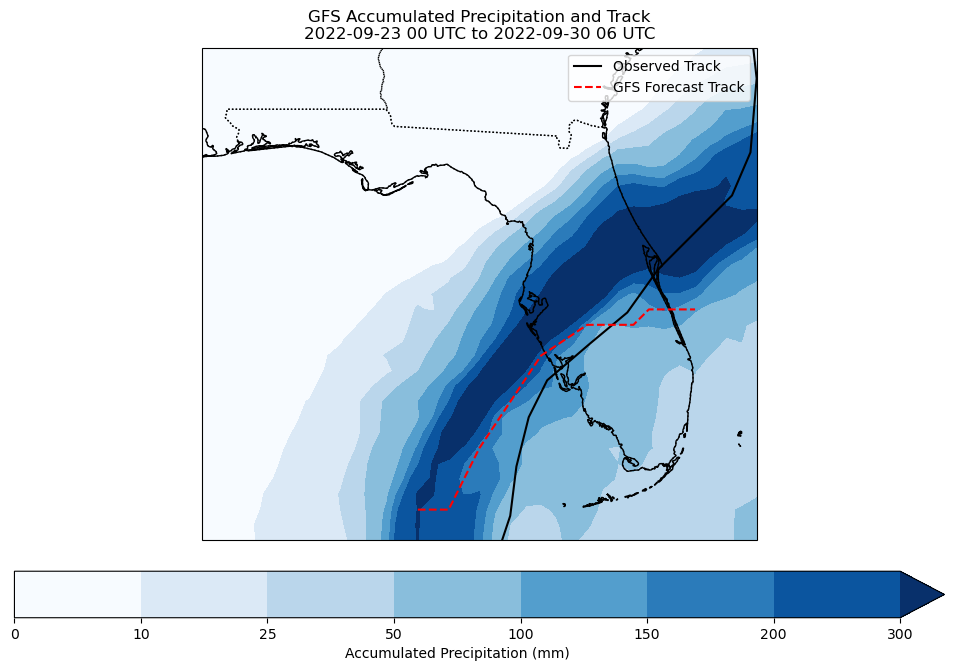

In [56]:
observed_track = pd.read_csv("/home/zas5258/meteo473/ianpreliminarytrack.csv")
obs_lats = observed_track['LAT']
obs_lons = observed_track['LON']

florida_bounds = {
    'lat_min': 24.396308,
    'lat_max': 31.000968,
    'lon_min': -87.634938,
    'lon_max': -79.974307
}

forecast_run_date = dt.datetime(2022, 9, 23, 0)
forecast_hours = range(102, 180, 6)

storm_points = []
total_precip = None

for fxx in forecast_hours:
    try:
        H = Herbie(forecast_run_date, model="gfs", product="pgrb2.0p25", fxx=fxx)
        H.download()
        
        # Load both variables at once
        ds_slp = H.xarray("PRMSL:mean sea level", verbose=False)
        ds_slp = ds_slp[0] if isinstance(ds_slp, list) else ds_slp
        ds_slp = ds_slp.assign_coords(longitude=(((ds_slp.longitude + 180) % 360) - 180)).sortby('longitude')
        ds_fl = ds_slp.sel(
            latitude=slice(florida_bounds['lat_max'], florida_bounds['lat_min']),
            longitude=slice(florida_bounds['lon_min'], florida_bounds['lon_max'])
        )
        min_idx = np.unravel_index(ds_fl['prmsl'].argmin().values, ds_fl['prmsl'].shape)
        storm_lat = ds_fl.latitude.values[min_idx[0]]
        storm_lon = ds_fl.longitude.values[min_idx[1]]
        storm_mslp = ds_fl['prmsl'].values[min_idx] / 100  # Pa to hPa
        storm_points.append({
            "longitude": storm_lon,
            "latitude": storm_lat,
            "valid_time": str(ds_fl.valid_time.values),
            "MSLP": storm_mslp
        })

        # Precipitation
        ds_precip = H.xarray(":APCP:surface", verbose=False)
        ds_precip = ds_precip[0] if isinstance(ds_precip, list) else ds_precip
        precip = ds_precip['tp'] * 1  # kg/m^2 to mm
        total_precip = precip if total_precip is None else total_precip + precip

    except Exception as e:
        print(f"Error at fxx={fxx}: {e}")
        continue

df_storm = pd.DataFrame(storm_points)

# Plotting
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-88, -79, 24, 32])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=':')
ax.add_feature(cfeature.BORDERS, linestyle=':')
levels = [0, 10, 25, 50, 100, 150, 200, 300]
cf = total_precip.plot.contourf(ax=ax, levels=levels, cmap='Blues', 
                               transform=ccrs.PlateCarree(), add_colorbar=False)
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.05)
cbar.set_label('Accumulated Precipitation (mm)')
ax.plot(obs_lons, obs_lats, 'k-', label='Observed Track', transform=ccrs.PlateCarree())
ax.plot(df_storm['longitude'], df_storm['latitude'], 'r--', label='GFS Forecast Track', transform=ccrs.PlateCarree())
ax.set_title(f"GFS Accumulated Precipitation and Track\n{forecast_run_date:%Y-%m-%d %H} UTC to " +
             f"{(forecast_run_date + dt.timedelta(hours=max(forecast_hours))):%Y-%m-%d %H} UTC")
ax.legend()
plt.show()

## Step 4

This step plots and displays the 10-meter wind field from the GFS forecast.

- Wind speed and direction are visualized using vector arrows or streamlines on a map.
- The data corresponds to the selected forecast hour and domain.
- Map features and projection ensure accurate geographic representation.
- This visualization helps understand near-surface wind patterns, which are important for weather impacts and forecasting.

We can see from the plot that the strongest predicted 10-m winds circulated and converged around where Hurricane Ian was predicted to make landfall, and the winds weakened as they got further from the center of the storm.

✅ Found ┊ model=gfs ┊ product=pgrb2.0p25 ┊ 2022-Sep-28 00:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws


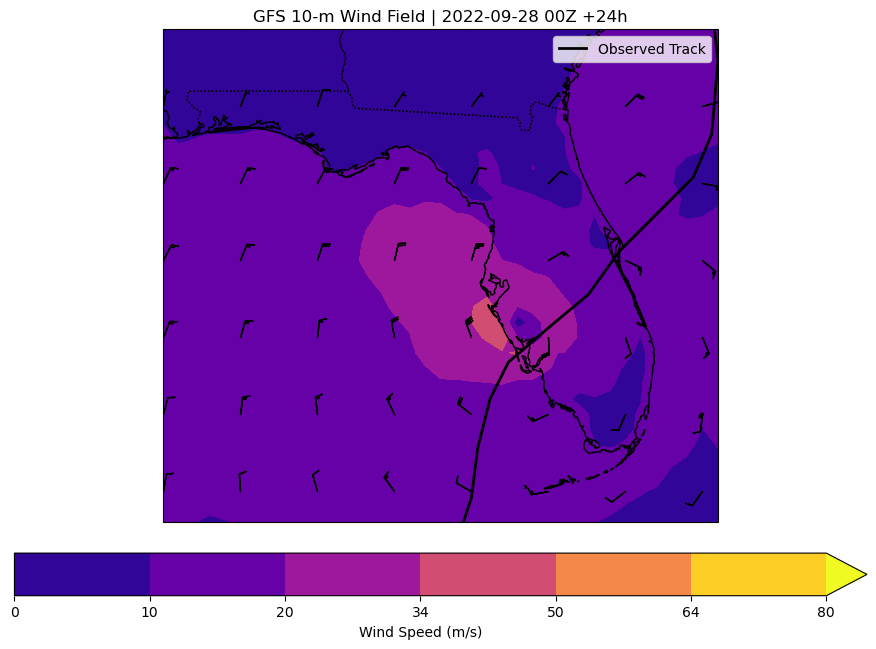

In [61]:
# Set your time and domain
forecast_run_date = dt.datetime(2022, 9, 28, 0)
fxx = 24  # Forecast hour of interest

# Load wind data
H = Herbie(forecast_run_date, model="gfs", product="pgrb2.0p25", fxx=fxx)
ds_u = H.xarray("UGRD:10 m above ground", verbose=False)
ds_v = H.xarray("VGRD:10 m above ground", verbose=False)
ds_u = ds_u[0] if isinstance(ds_u, list) else ds_u
ds_v = ds_v[0] if isinstance(ds_v, list) else ds_v

# Adjust longitude to [-180, 180]
ds_u = ds_u.assign_coords(longitude=(((ds_u.longitude + 180) % 360) - 180)).sortby('longitude')
ds_v = ds_v.assign_coords(longitude=(((ds_v.longitude + 180) % 360) - 180)).sortby('longitude')

# Subset over Florida
lat_min, lat_max = 24, 32
lon_min, lon_max = -88, -79
ds_u = ds_u.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))
ds_v = ds_v.sel(latitude=slice(lat_max, lat_min), longitude=slice(lon_min, lon_max))

# Compute wind speed
u = ds_u['u10'].values
v = ds_v['v10'].values
wind_speed = np.sqrt(u**2 + v**2)

# Plot
fig, ax = plt.subplots(figsize=(11, 8), subplot_kw={'projection': ccrs.PlateCarree()})
ax.set_extent([lon_min, lon_max, lat_min, lat_max])
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle=":")

# Wind speed shading
levels = [0, 10, 20, 34, 50, 64, 80] 
cf = ax.contourf(ds_u.longitude, ds_u.latitude, wind_speed, levels=levels, cmap='plasma', extend='max')

# Optionally overlay wind barbs (subsample for clarity)
skip = (slice(None, None, 5), slice(None, None, 5))
ax.barbs(ds_u.longitude.values[skip[1]], ds_u.latitude.values[skip[0]], u[skip], v[skip], length=5)

# Add colorbar
cbar = plt.colorbar(cf, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label('Wind Speed (m/s)')

# Overlay the observed storm track
observed_track = pd.read_csv("ianpreliminarytrack.csv")
ax.plot(observed_track['LON'], observed_track['LAT'], 'k-', lw=2, label='Observed Track')

ax.set_title(f"GFS 10-m Wind Field | {forecast_run_date:%Y-%m-%d %HZ} +{fxx}h")
plt.legend()
plt.show()
